# Kaggle House Prices Project :

The objective of the project is to predict the SalePrice of the houses we have in our datasets using differents features available. We have 2 datasets : one for training and one used to make the final predictions.  
We will first explore the datasets to get some insight and analyze SalePrice distribution. 
Then try to fill the missing values and clean the datasets of its differents outliers.
With the datasets a bit cleaner we will see the correlation between the features.
And finally after a bit of feature engineering and feature selection we will develop the different models used to make the predictions.

I'll try to write it in english as an exercise as it's not my main language.

In [ ]:
# Libraries :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform
from pathlib import Path
import pickle
import time

# Model dev part :
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

In [133]:
path = Path('train.csv').parent.absolute()
train=pd.read_csv(path/'data/train.csv')
test=pd.read_csv(path/'data/test.csv')

train.drop(["Id", "Utilities"],axis=1,inplace=True) # Deleting Id and Utilities, a feature later found to have only two classes with only one observation in one of them.
test.drop(["Id", "Utilities"],axis=1,inplace=True)

## 1 - Exploratory Data Analysis :

### Global exploration :

In [134]:
print("Shape of the train : ", train.shape)
print("Shape of the test : ", test.shape)

train.info()

Shape of the train :  (1460, 79)
Shape of the test :  (1459, 78)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   

We have a dataset already split in train/test. It was split in a 50/50 way with 1460 in each set. The test will be used for the submission.

We have 78 features and 1 target (SalePrice), 42 of them are qualitatives features. The info function allows us to see some features with many missing value (ex : Alley only has 91 non-missing values). We can note that we have approximately 18 obs / feature, we are pretty good with respect to the curse of dimensionnality (to be safe we need at least 10 to 15 obs / feature).

### Statistical Exploration of SalePrice:

In [135]:
print(train['SalePrice'].describe())
print('Kurtosis : ', train['SalePrice'].kurt())
print('Skewness : ', train['SalePrice'].skew())

# Positive skewness => log transformation works well

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Kurtosis :  6.536281860064529
Skewness :  1.8828757597682129


P-value of Shapiro-Wilk's normality test : 3.2061412312021656e-33


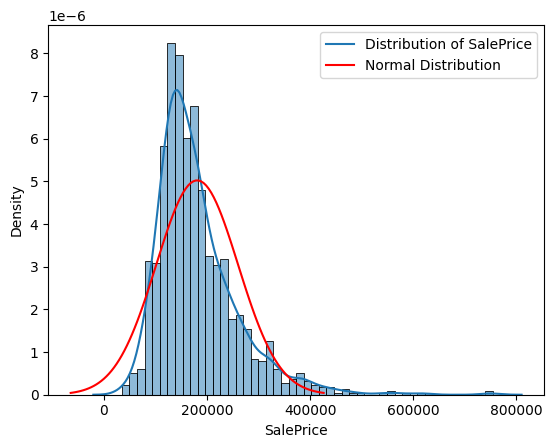

In [136]:
sns.histplot(train['SalePrice'],kde=True,stat='density',kde_kws=dict(cut=3)) #kde:curve, density:frequency, kde_kws:to make the curve go further than the hist boxes
(mu,sigma)=stats.norm.fit(train['SalePrice'])
x_dummy = np.linspace(stats.norm.ppf(0.001,mu, sigma), stats.norm.ppf(0.999,mu,sigma), 100)
plt.plot(x_dummy, stats.norm.pdf(x_dummy,mu,sigma),c='red')
plt.legend(["Distribution of SalePrice","Normal Distribution"])

print("P-value of Shapiro-Wilk's normality test :", stats.shapiro(train['SalePrice']).pvalue)
# => p-value very low, we reject H0 : the distribution is not normal.

P-value of Shapiro-Wilk's normality test : 1.1490615527264654e-07


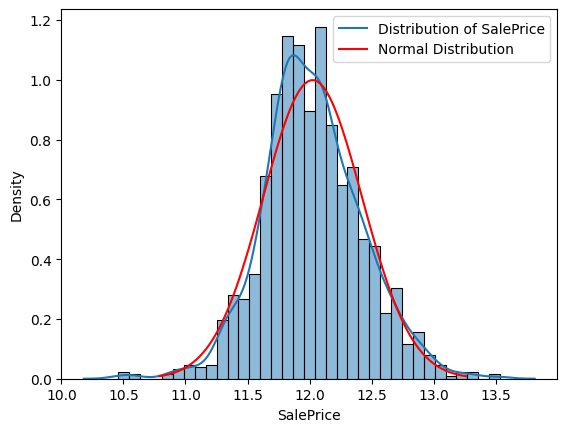

In [137]:
sns.histplot(np.log(train['SalePrice']),kde=True,stat='density',kde_kws=dict(cut=3)) #kde:curve, density:frequency, kde_kws:to make the curve go further than the hist boxes
(mu,sigma)=stats.norm.fit(np.log(train['SalePrice']))
x_dummy = np.linspace(stats.norm.ppf(0.001, mu, sigma), stats.norm.ppf(0.999,mu,sigma), 100)
plt.plot(x_dummy, stats.norm.pdf(x_dummy,mu,sigma),c='red')
plt.legend(["Distribution of SalePrice","Normal Distribution"])

print("P-value of Shapiro-Wilk's normality test :", stats.shapiro(np.log(train['SalePrice'])).pvalue)
# => Much better but still not good.

### Missing data :

In [138]:
data=pd.concat([train.drop('SalePrice',axis=1),test],axis=0)
data.shape

(2919, 78)

In [139]:
count = data.isna().sum()[data.isna().sum()>0].sort_values(ascending=False)
perc = round(count/data.shape[0],3)
miss=pd.concat([count,perc,data[perc.index].dtypes],axis=1,keys=("Count","Percentage","Type"))
miss

,Count,Percentage,Type
PoolQC,2909,0.997,object
MiscFeature,2814,0.964,object
Alley,2721,0.932,object
Fence,2348,0.804,object
MasVnrType,1766,0.605,object
FireplaceQu,1420,0.486,object
LotFrontage,486,0.166,float64
GarageYrBlt,159,0.054,float64
GarageFinish,159,0.054,object
GarageCond,159,0.054,object


In [140]:
# Looking at the data description file for insight on what to fill instead of NA : 

for col in ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","MasVnrType","GarageType","GarageQual","GarageCond","GarageFinish","BsmtCond",
            "BsmtQual","BsmtExposure","BsmtFinType1","BsmtFinType2"] : #Those features are filled with NA when there is no structure associated (No garage, no pool, no basement, ...)
    data[col] = data[col].fillna("None")

for col in ["GarageYrBlt","BsmtFullBath","BsmtHalfBath","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","GarageCars","GarageArea"] : 
    data[col] = data[col].fillna(0) # Comes from the fact that without the structure you can't have a certain number of object (0 car in garage without garage, 0 bath in basement ....)
    
for col in ['Functional',"Exterior1st","Exterior2nd","Electrical","KitchenQual","SaleType"] : 
    data[col] = data[col].fillna(data[col].mode()[0]) # Those are categoricals features that shouldn't be NAs and i didn't have a particular insight on what to fill it with
        
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median())) # This value depend on the neighbor we're in so I found the idea of a groupby interesting in the notebook : https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
data['MSZoning'] = data.groupby('MSSubClass')['MSZoning'].transform(lambda x : x.fillna(x.mode()[0])) # Same over here

In [141]:
count = data.isna().sum()[data.isna().sum()>0].sort_values(ascending=False)
perc = round(count/data.shape[0],3)
miss=pd.concat([count,perc,data[perc.index].dtypes],axis=1,keys=("Count","Percentage","Type"))
miss

,Count,Percentage,Type


In [142]:
train = pd.concat([data.iloc[:train.shape[0],:],train["SalePrice"]],axis=1)
test = data.iloc[train.shape[0]:,:]

### Outliers : 


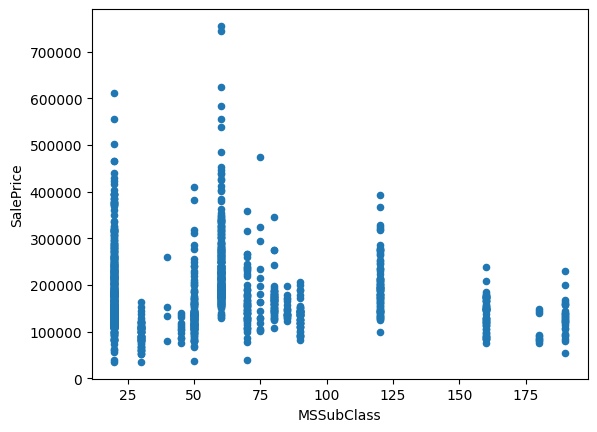

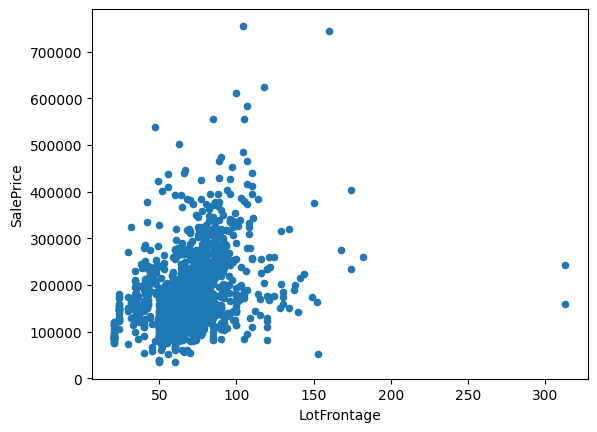

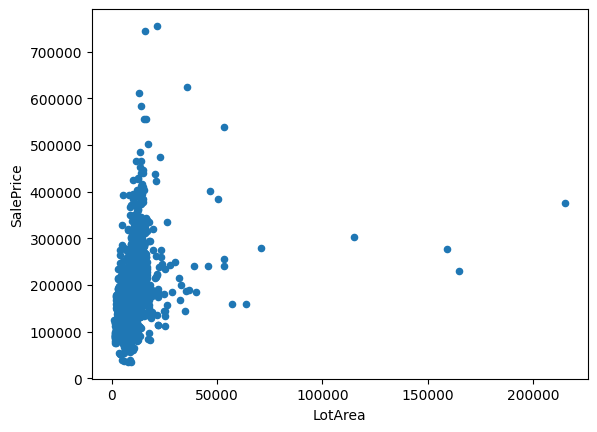

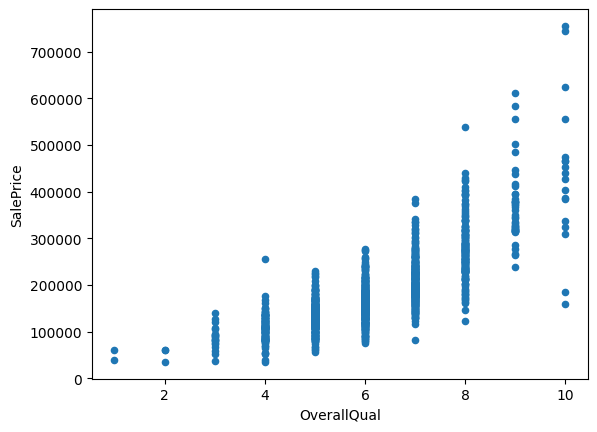

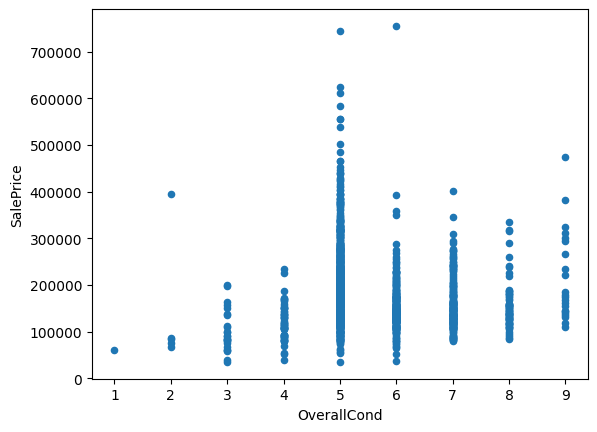

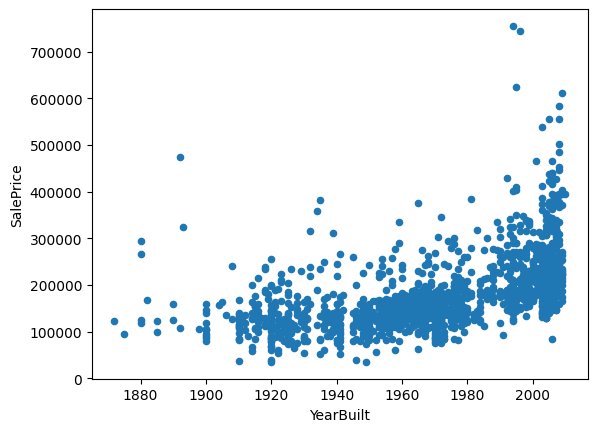

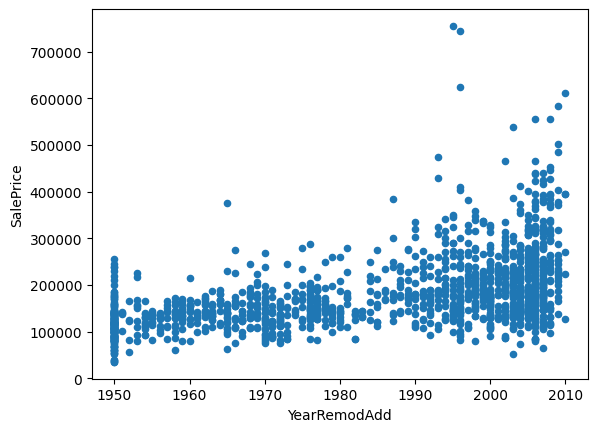

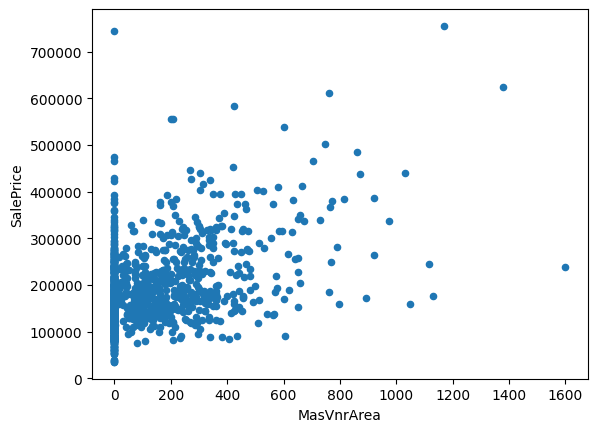

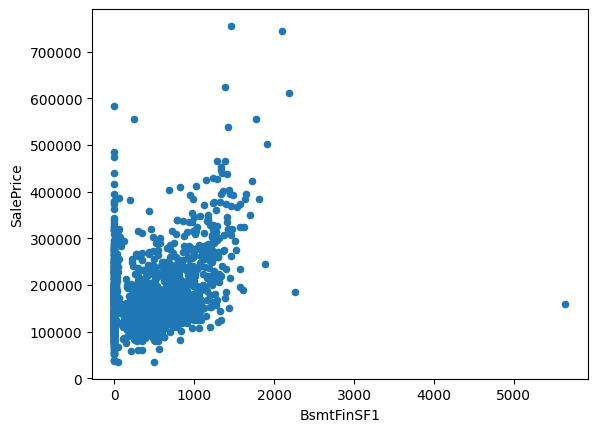

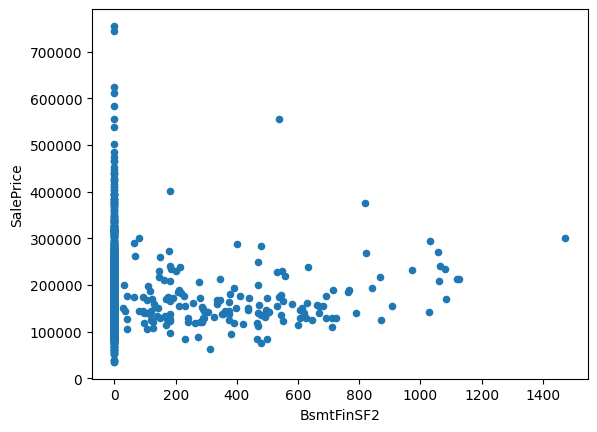

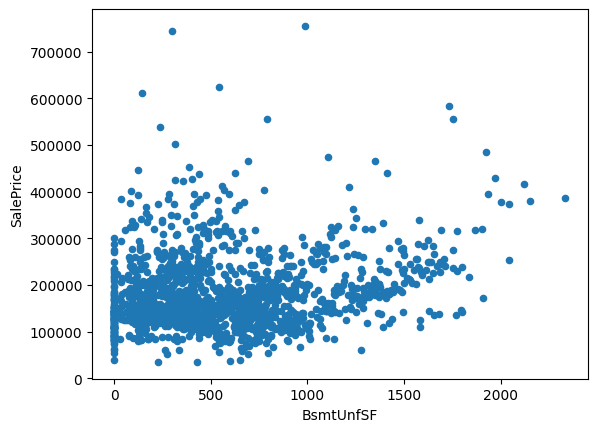

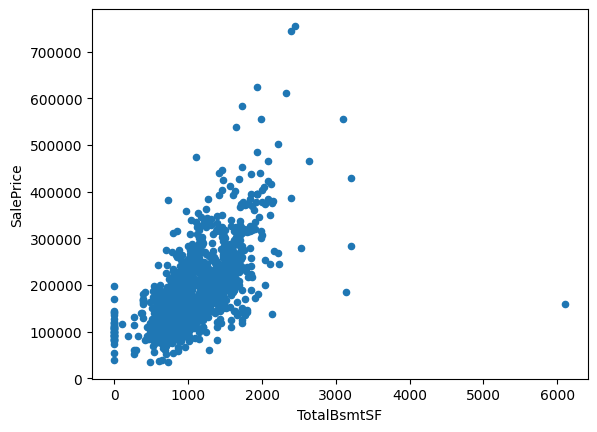

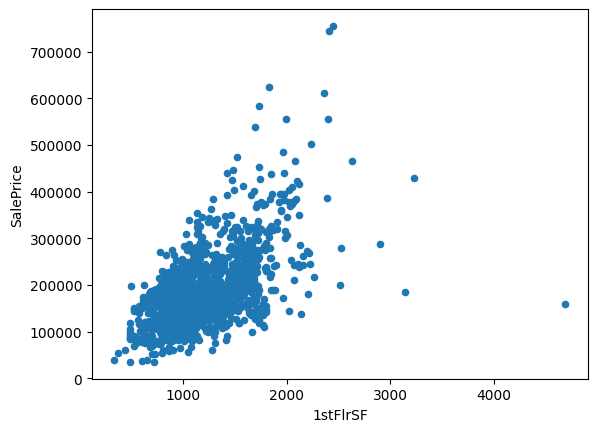

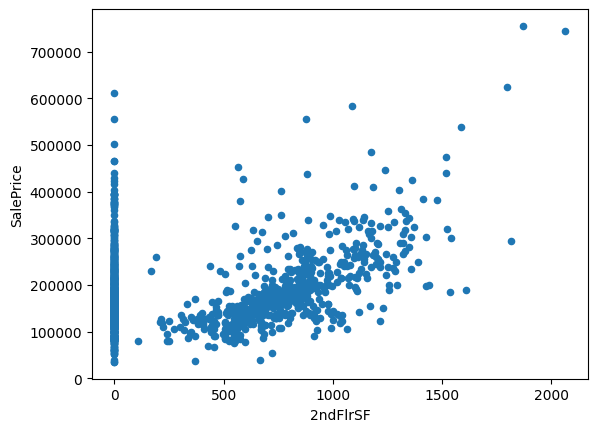

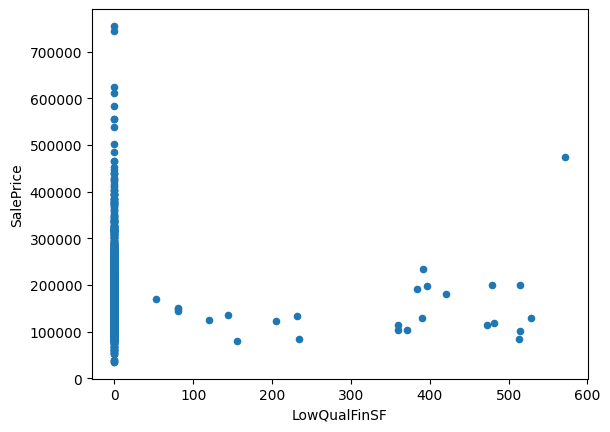

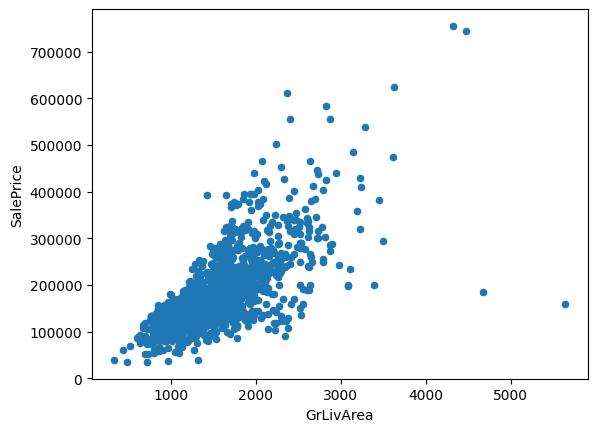

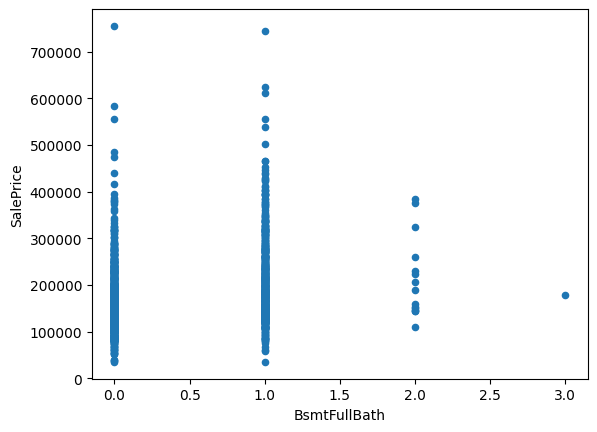

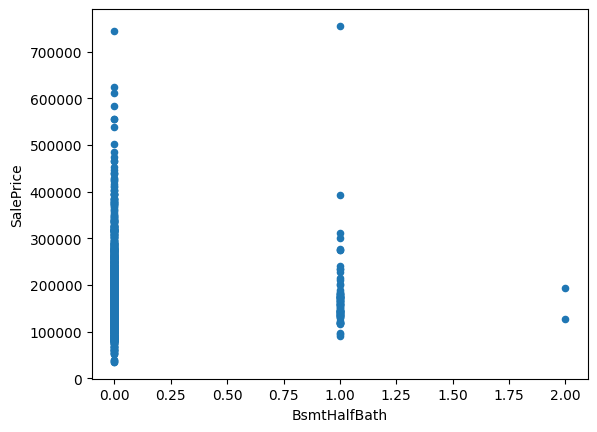

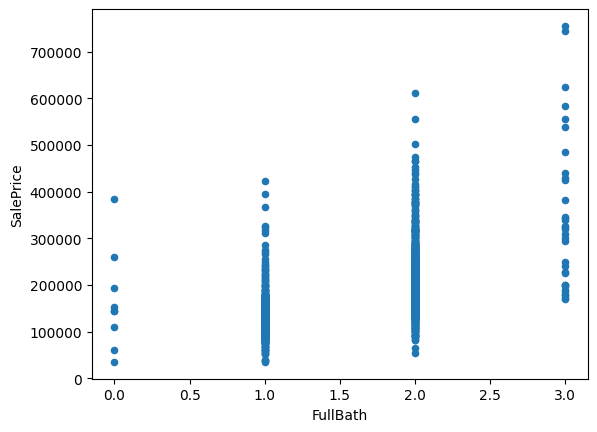

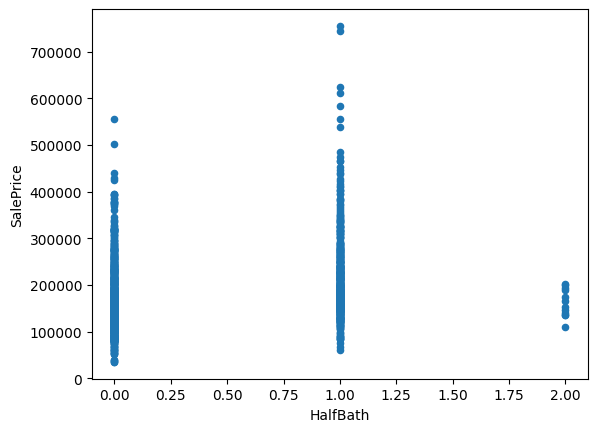

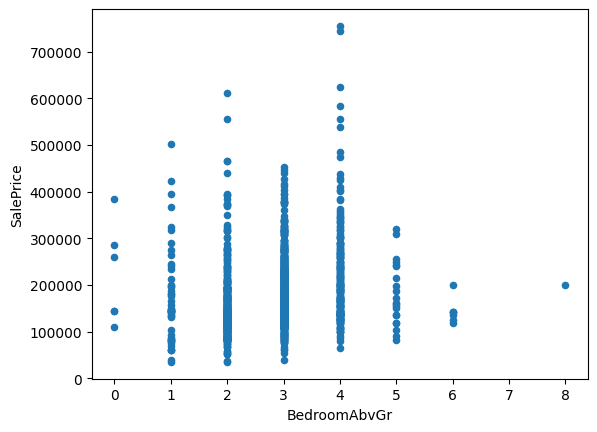

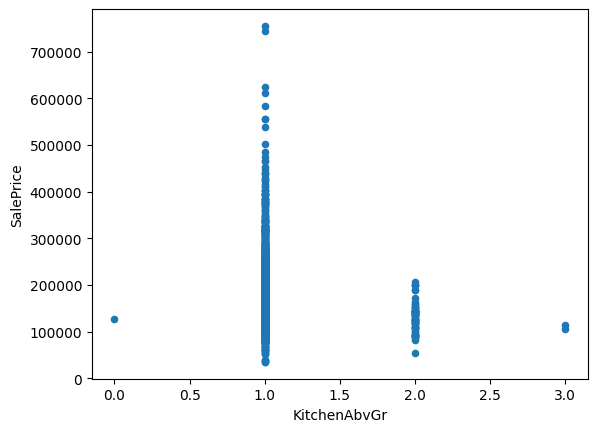

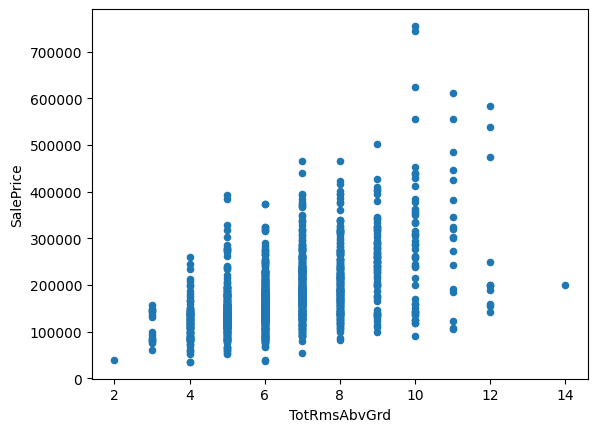

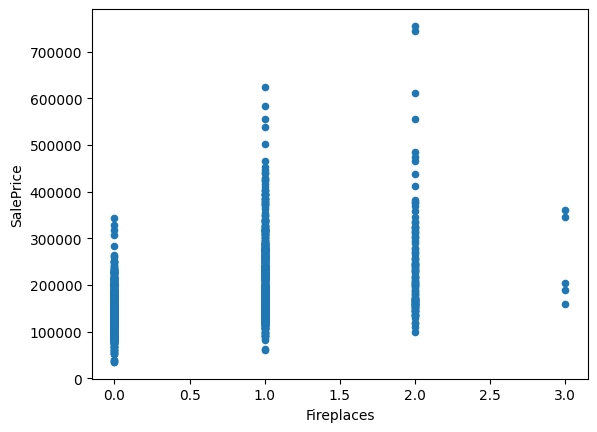

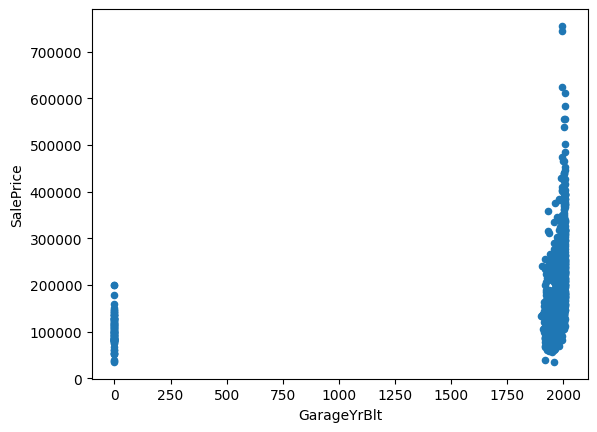

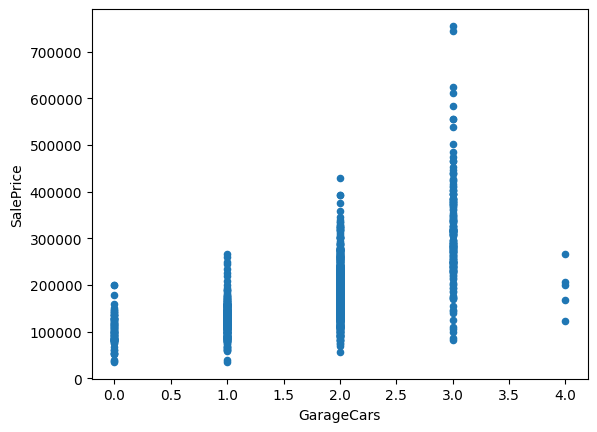

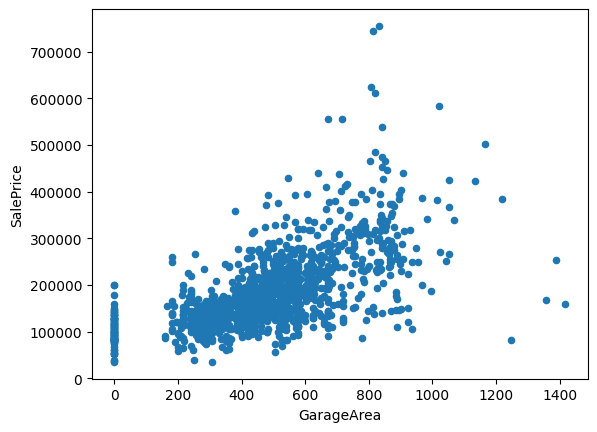

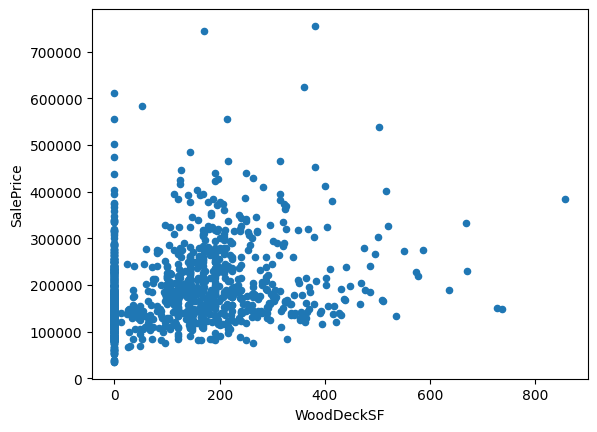

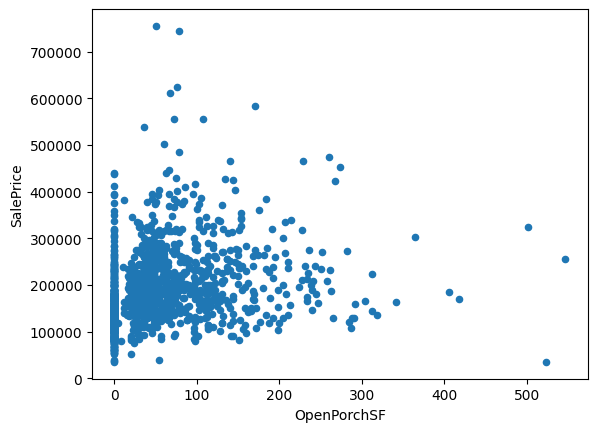

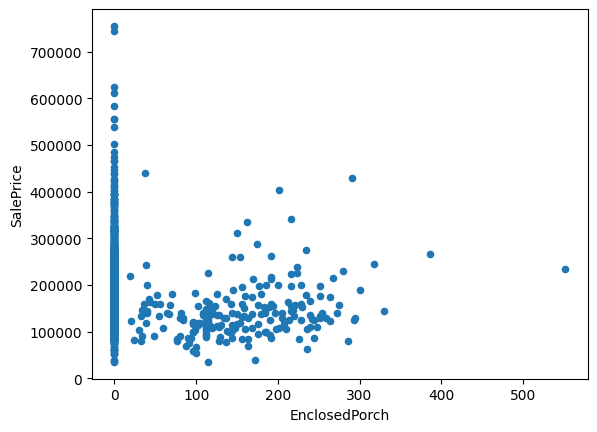

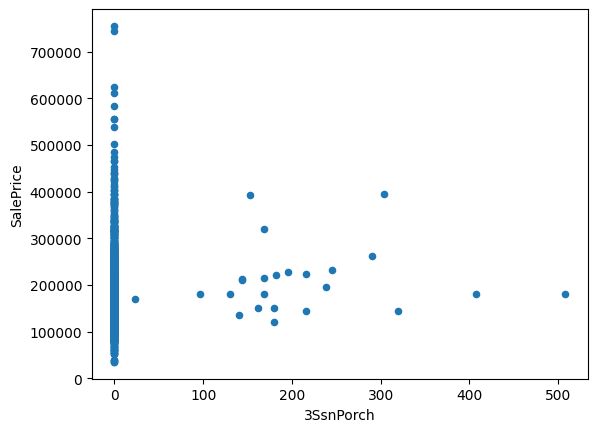

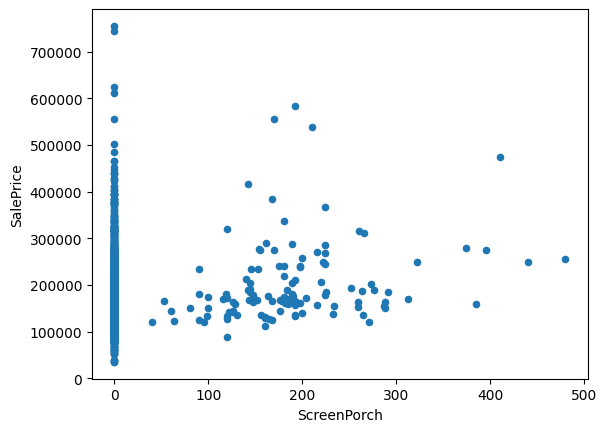

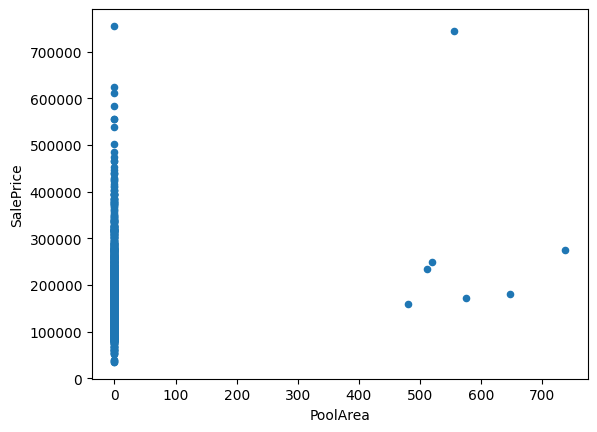

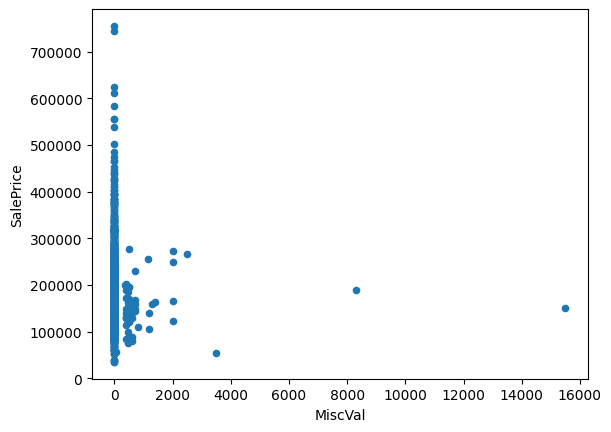

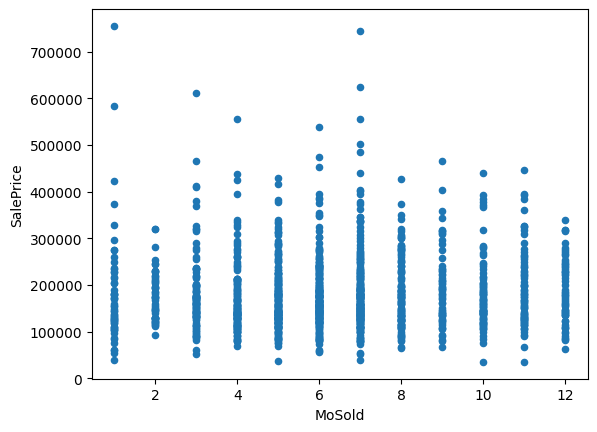

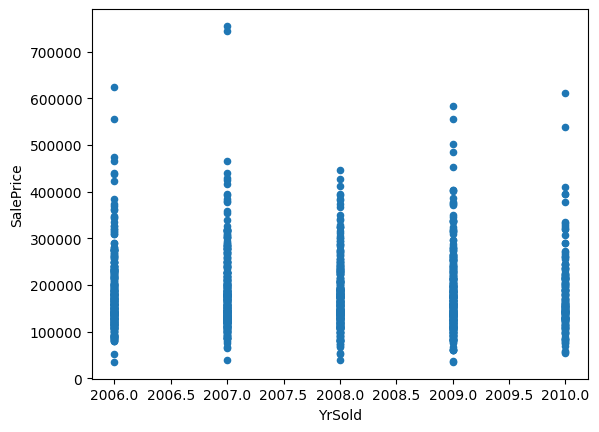

In [143]:
for var in train.columns :
  if train[var].dtype in ['int64','float64'] and var != "SalePrice" : # Only for numerical features
    sample = pd.concat([train["SalePrice"],train[var]],axis=1)
    sample.plot.scatter(x=var, y='SalePrice')
    plt.show()

In [144]:
train.drop(train[train['LotArea']>100000].index,axis=0,inplace=True)
train.drop(train[train['LotFrontage']>300].index,axis=0,inplace=True)
train.drop(train[train['MiscVal']>6000].index,axis=0,inplace=True)
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index,axis=0,inplace=True)
train.drop(train[(train['1stFlrSF']>4000) & (train['SalePrice']<300000)].index,axis=0,inplace=True)

### Correlation :

In [145]:
qualitative = [ f for f in train.columns if train.dtypes[f]=="object"]
quantitative = [ f for f in train.columns if train.dtypes[f]!="object"]

#### Qualitative features :

##### Anova :

In [146]:
# Statistical test for ANOVA :

# 1 - Normality within each group : we know that SalePrice doesn't follow a normal distribution but does it follow a normal distribution wrt each group of categorical features :

result=list()
result_log=list()
for var in qualitative : # In my qualitative variable
    for cate in train[var].unique() : # In my categories
        sample = train[train[var]==cate]['SalePrice']
        sample_log = np.log(train[train[var]==cate]['SalePrice'])
        try : # If we have a size error in shapiro we will say it's false
          res=stats.shapiro(sample).pvalue
          result.append(res>=0.1)
        except :
          result.append(False)
        try :
          res_log=stats.shapiro(sample_log).pvalue
          result_log.append(res_log>=0.1)
        except :
          result_log.append(False)
print(f"Percentage of normality : {round(100*np.sum(result)/len(result),2)}%")
print(f"Percentage of normality (log) : {round(100*np.sum(result_log)/len(result_log),2)}%")

# Even with the transformation we don't meet the standard to use ANOVA. We can't guarantee the interpretability of the result for the variable selection
# but let's use it anyway to have an idea and example.

# 2 - Homogénéité des Variances :
# Hypothèse : Les variances de SalePrice devraient être similaires entre les différents groupes de la variable catégorielle.
# Test : Utilisez le test de Levene ou le test de Bartlett pour tester l'homogénéité des variances entre groupes.
#         from scipy.stats import levene
# Une p-value inférieure à 0.05 indique une hétérogénéité des variances, ce qui pourrait remettre en question la validité de l'ANOVA.

# Si certaines de ces hypothèses sont violées, vous pouvez envisager des solutions alternatives :

# Si l'hypothèse de normalité est violée, transformer la variable dépendante (par exemple, en utilisant une transformation logarithmique) peut parfois aider.
# En cas d'hétérogénéité des variances, envisagez une ANOVA robuste (comme la Welch's ANOVA) ou une Kruskal-Wallis ANOVA qui est une alternative non paramétrique ne nécessitant pas l'homogénéité des variances.


C:\Users\laffi\AppData\Local\Temp\ipykernel_8008\3402885455.py:12: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res=stats.shapiro(sample).pvalue
C:\Users\laffi\AppData\Local\Temp\ipykernel_8008\3402885455.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res_log=stats.shapiro(sample_log).pvalue


Percentage of normality : 24.52%
Percentage of normality (log) : 37.55%


In [147]:
# def anova(data): #https://www.kaggle.com/code/dgawlik/house-prices-eda#Categorical-data
#     anv = pd.DataFrame({'feature': qualitative})
#     pvals = []
#     for c in qualitative: # Parcours les variable qualitative
#         samples = []
#         for cls in data[c].unique(): # Parcours les groupes de la colonne c de train
#             s = data[data[c] == cls]['SalePrice'].values
#             samples.append(s)  # Je recupere les valeurs de SalePrice des individus (ordonné par groupe)
#         pval = stats.f_oneway(*samples)[1] # Je recupère la p-value de l'anova
#         pvals.append(pval)
#     anv['pval'] = pvals
#     return anv.sort_values('pval')

# a = anova(train)
# a['disparity'] = np.log(1./a['pval'].values) # log(1/p) : pour faciliter la visualisation, petite p-value <=> grand disparity ;
#                                              # petite p-val (<0.05) => la catégorie influe dans les variations de SalePrice
# sns.barplot(data=a, x='feature', y='disparity')
# x=plt.xticks(rotation=90)

#### Quantitative features :

##### Ordinal encoding based on the mean of SalePrice :

In [148]:
def encode(frame, feature): # Taken from : https://www.kaggle.com/code/dgawlik/house-prices-eda#Categorical-data
    ordering = pd.DataFrame({'val' : frame[feature].unique()})
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature,observed=False).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)  
    ordering = ordering['ordering'].to_dict() 

    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
        
qual_encoded = []
train_encoded=train.copy()
for q in qualitative:
    encode(train_encoded, q)
    qual_encoded.append(q+'_E')
train_encoded.drop(qualitative,axis=1,inplace=True) # A new dataframe with encoded features 

##### Heatmap :

In [149]:
corr_qual=train_encoded[qual_encoded].corr(method="spearman") #Only qualitative features
corr_quant=train_encoded[quantitative].corr(method="spearman") #Only quantitative features
corr_cross=pd.DataFrame(np.zeros([len(qual_encoded),len(quantitative)]),index=qual_encoded,columns=quantitative) #Between qualitatives and quantitatives
for var1 in qual_encoded :
  for var2 in quantitative :
    corr_cross.loc[var1,var2]=train_encoded[var1].corr(train_encoded[var2],method="spearman")

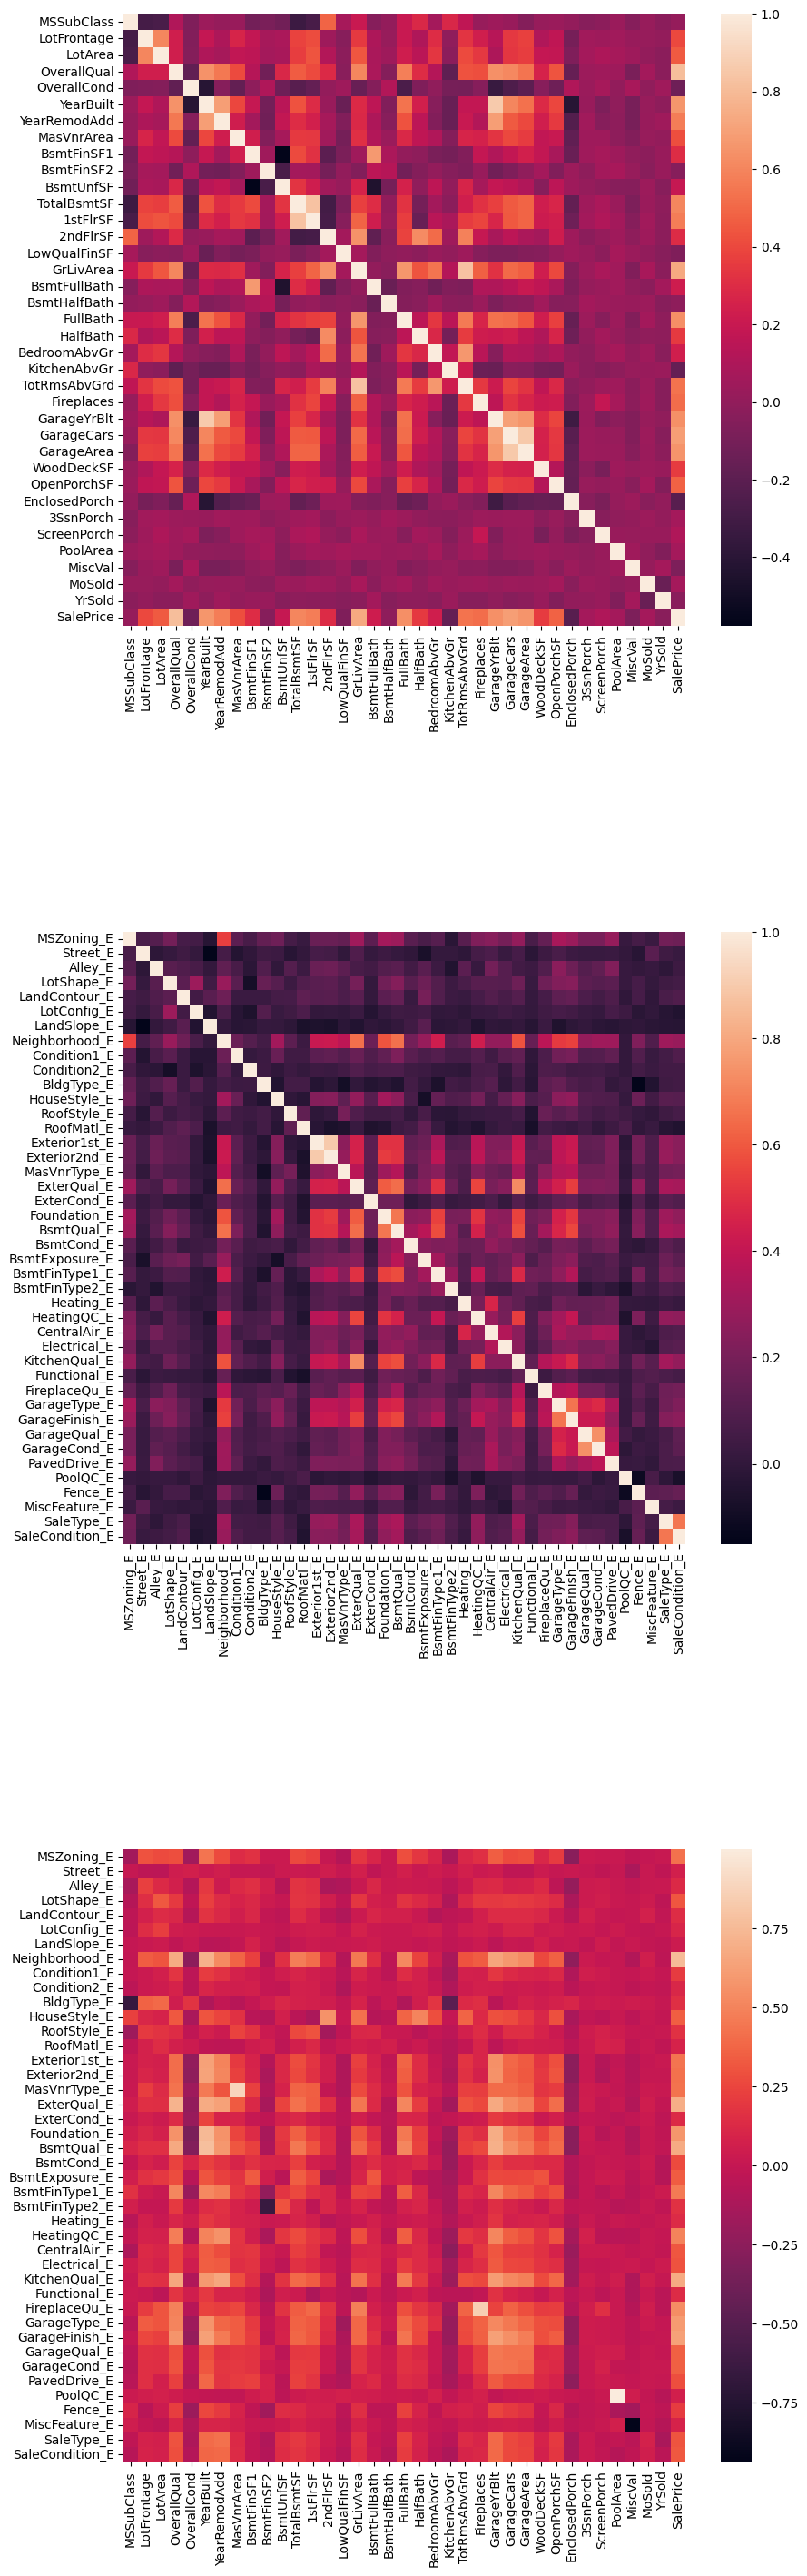

In [150]:
plt.figure(figsize=(10,35))
plt.subplot(3,1,1)
sns.heatmap(corr_quant,)
plt.subplot(3,1,2)
sns.heatmap(corr_qual)
plt.subplot(3,1,3)
sns.heatmap(corr_cross)

plt.subplots_adjust(hspace=0.5)
plt.show()

##### Correlation with SalePrice :

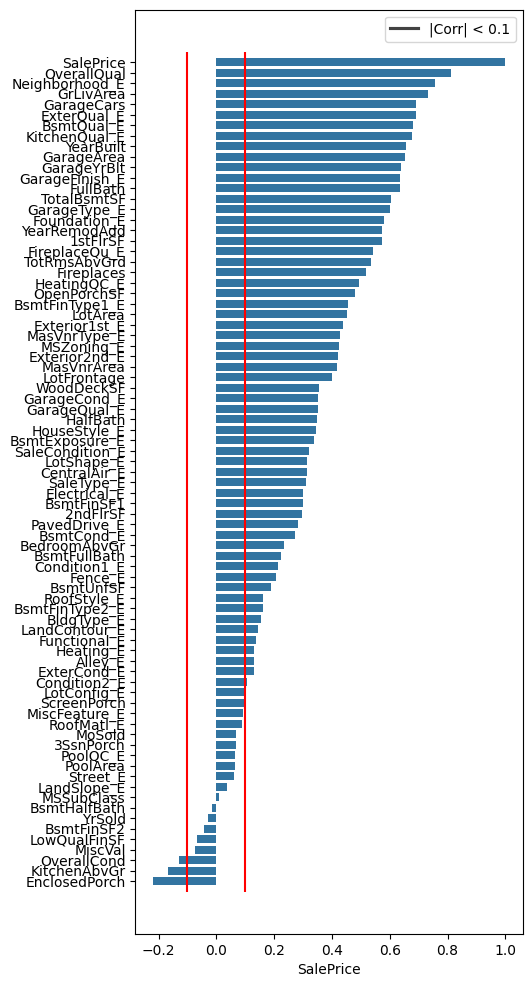

In [151]:
corr_cible=pd.concat([corr_cross['SalePrice'],corr_quant['SalePrice']])
corr_cible.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(5,12))
sns.barplot(corr_cible,orient='h')
plt.vlines(0.1,ymin=-1,ymax=len(corr_cible),colors='red')
plt.vlines(-0.1,ymin=-1,ymax=len(corr_cible),colors='red')
plt.legend(["|Corr| < 0.1"])
plt.show()

In [152]:
liste=corr_cible[abs(corr_cible)<0.1].index
print("Low value of correlation with SalePrice : \n", liste)

Low value of correlation with SalePrice : 
 Index(['MiscFeature_E', 'RoofMatl_E', 'MoSold', '3SsnPorch', 'PoolQC_E',
       'PoolArea', 'Street_E', 'LandSlope_E', 'MSSubClass', 'BsmtHalfBath',
       'YrSold', 'BsmtFinSF2', 'LowQualFinSF', 'MiscVal'],
      dtype='object')


## 2 - Model creation :

### Feature engineering :

In [153]:
data=pd.concat([train.drop('SalePrice',axis=1),test],axis=0)

# Category to create : 
data['HasPool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['HasScreenPorch'] = data['ScreenPorch'].apply(lambda x: 1 if x > 0 else 0)
data['Has3SeasonPorch'] = data['3SsnPorch'].apply(lambda x: 1 if x > 0 else 0)
data['HasEnclosedPorch'] = data['EnclosedPorch'].apply(lambda x: 1 if x > 0 else 0)
data['HasOpenPorchSF'] = data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasWoodDeckSF'] = data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasGarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['HasBasement'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['Has2ndFloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasVeneer'] = data['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)

# One-Hot Encoding : 
data=pd.get_dummies(data).reset_index(drop=True)


# Getting back the train and test : 
y=np.log(train['SalePrice'].reset_index(drop=True)) # The results are evaluated between the log(SalePrice) of predicted and observed
train=data.iloc[:len(train),:]
test=data.iloc[len(train):,:]

# Keeping only top 100 corr because we don't have many observation, we want to have approximately 10 obs per features (here with 100 we have 14)
temp = pd.concat([pd.DataFrame(train),y],axis=1)
c=temp.corr(method='spearman')
print("Top 100 correlation with SalePrice :\n", abs(c['SalePrice']).sort_values(ascending=False)[1:101])

tr=train[abs(c['SalePrice']).sort_values(ascending=False)[1:101].index]
te=test[abs(c['SalePrice']).sort_values(ascending=False)[1:101].index]

# Normalization : 
scaler=StandardScaler()
scaler.fit(tr)
train_scaled = scaler.transform(tr)
test_scaled = scaler.transform(te)

print(train_scaled.shape, test_scaled.shape)

Top 100 correlation with SalePrice :
 OverallQual            0.813205
GrLivArea              0.731190
GarageCars             0.691627
YearBuilt              0.657662
GarageArea             0.651028
                         ...   
SaleType_WD            0.194520
Exterior2nd_MetalSd    0.193708
KitchenQual_Fa         0.193523
BsmtFinType2_None      0.192646
BsmtUnfSF              0.188555
Name: SalePrice, Length: 100, dtype: float64
(1451, 100) (1459, 100)


### Models :

#### Define the learning context :

In [154]:
# Splitting in train / test : 
X_train, X_test, y_train, y_test = train_test_split(train_scaled,y,test_size=0.3,random_state=1,shuffle=True) # 70/30%

# Hypeparameters optimisation : 
def cv(model,distrib,X=X_train,y=y_train) : 
    process = RandomizedSearchCV (estimator=model,param_distributions=distrib,n_iter=50,scoring="neg_root_mean_squared_error",cv=5,verbose=0,n_jobs=-1,random_state=1)
    process.fit(X,y)
    return process.best_params_, -process.best_score_

#### Definition : 

In [155]:
# Define the differents models and there distribution for RandomCV : 

ridge = Ridge()
ridge_distrib = {'alpha': uniform(0.0001,100)} 

lasso = Lasso()
lasso_distrib = {'alpha': uniform(0.0001,100)} 

elastic_net = ElasticNet()
elastic_net_distrib = {'alpha': uniform(0.001,10), 'l1_ratio' :  uniform(0.1,0.8)}

svr = SVR(gamma='scale', kernel='rbf')
svr_distrib = {'C' : uniform(0.01,50), 'epsilon' : uniform(0.001,0.999),} 

rf = RandomForestRegressor()
rf_distrib = {'n_estimators' : randint(100,501),'max_depth':[None, 10, 20, 30, 50], 'min_samples_split': randint(2,11),
           'min_samples_leaf': randint(1,6), 'max_features':["sqrt", "log2"]} 

xgb = XGBRegressor()
xgb_distrib = {'n_estimators' : randint(100,501), 'max_depth': randint(1,11), 'subsample': uniform(0.5,0.5), 'learning_rate' : uniform(0.001,0.3), 'colsample_bytree': uniform(0.5,0.5),
            'gamma' : uniform(0,5), 'reg_alpha' : uniform(0.1,10), 'reg_lambda' : uniform(0.1,10)} # 729 combinations

lgb = LGBMRegressor(verbose=-1) 
lgb_distrib = {'n_estimators' : randint(100,501), 'max_depth': randint(1,11), 'subsample': uniform(0.5,0.5), 'learning_rate' : uniform(0.001,0.3), 'colsample_bytree': uniform(0.5,0.5),
            'reg_alpha' : uniform(0.1,10), 'reg_lambda' : uniform(0.1,10), 'num_leaves' : randint(10,51)}
    
models = [ridge, lasso, elastic_net, svr, rf, xgb, lgb]
distribs = [ridge_distrib, lasso_distrib, elastic_net_distrib, svr_distrib, rf_distrib, xgb_distrib, lgb_distrib]
model_names=['Ridge','Lasso','ElasticNet','SVR','RandomForest','Xgboost','LightGB']

#### Optimization of hyperparameters : 

In [156]:
params=dict()
res=dict()
times=dict()
for (model, distrib, model_name) in zip(models,distribs,model_names) : 
    print(model_name)
    start=time.time()
    param, score =cv(model,distrib)
    end=time.time()
    print(end-start)
    params[model_name]=param
    res[model_name]=score
    times[model_name]=end-start

Ridge
3.184999704360962
Lasso
0.3769998550415039
ElasticNet
0.4459991455078125
SVR
0.9130034446716309
RandomForest
30.414515495300293
Xgboost
6.366999387741089
LightGB
15.119997024536133


#### Saving : 

In [157]:
# Save the optimized hyperparameters :
MODEL_PATH=Path("Models parameters & Data")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH/'saved_dictionary.pkl'

print(f"Saving parameters to {MODEL_PATH/'saved_params.pkl'}")
with open(MODEL_PATH/'saved_params.pkl', 'wb') as f:
    pickle.dump(params, f)
    
print(f"Saving scores to {MODEL_PATH/'saved_scores_cv.pkl'}")
with open(MODEL_PATH/'saved_scores_cv.pkl', 'wb') as f:
    pickle.dump(res, f)
    
print(f"Saving times to {MODEL_PATH/'saved_times_cv.pkl'}")
with open(MODEL_PATH/'saved_times_cv.pkl', 'wb') as f:
    pickle.dump(times, f)
    
print(f"Saving data in {MODEL_PATH} folder")
tr.to_csv(MODEL_PATH/'train_final.csv', index=False)  
te.to_csv(MODEL_PATH/'test_final.csv', index=False)  
y.to_csv(MODEL_PATH/'y_final.csv', index=False)  

Saving parameters to Models parameters & Data\saved_params.pkl
Saving scores to Models parameters & Data\saved_scores_cv.pkl
Saving times to Models parameters & Data\saved_times_cv.pkl
Saving data in Models parameters & Data folder


### Loading back : (To start from here)

In [158]:
path=Path(Path('train_final.csv').parent.absolute(),Path("Models parameters & Data"))
with open(path/'saved_params.pkl', 'rb') as f: # Optimized parameters
    loaded_dict = pickle.load(f)

with open(path/'saved_scores_cv.pkl', 'rb') as f: # Score for the optimized parameters
    loaded_scores = pickle.load(f)
    
with open(path/'saved_times_cv.pkl', 'rb') as f: # times taken to optimize the parameters
    loaded_times = pickle.load(f)       
       
# Data : 
tr=pd.read_csv(path/'train_final.csv')
te=pd.read_csv(path/'test_final.csv')
y=pd.read_csv(path/'y_final.csv')

# Normalization :
scaler=StandardScaler()
scaler.fit(tr)
train_scaled = scaler.transform(tr)
test_scaled = scaler.transform(te)

print(train_scaled.shape, test_scaled.shape, y.shape)

# Splitting in train / test : 
X_train, X_test, y_train, y_test = train_test_split(train_scaled,y,test_size=0.3,random_state=1,shuffle=True) # 70/30%

# Models : 
ridge = Lasso(**loaded_dict['Ridge'])

lasso = Lasso(**loaded_dict['Lasso'])

elastic_net = ElasticNet(**loaded_dict['ElasticNet'])

svr = SVR(**loaded_dict['SVR'], gamma='scale', kernel='rbf')

rf = RandomForestRegressor(**loaded_dict['RandomForest'])

xgb = XGBRegressor(**loaded_dict['Xgboost'])

lgb = LGBMRegressor(**loaded_dict['LightGB'],verbose=-1) 

models = [ridge, lasso, elastic_net, svr, rf, xgb, lgb]
model_names=['Ridge','Lasso','ElasticNet','SVR','RandomForest','Xgboost','LightGB']

(1451, 100) (1459, 100) (1451, 1)


In [ ]:
# Try ensemble models : VotingRegressor, Blending could have been options

base_models = [
    ('ridge', ridge),
    ('lasso', lasso),
    ('elastic_net', elastic_net),
    ('svr', svr),
    ('rf', rf),
    ('xgb', xgb),
    ('lgb', lgb)
]

meta_model = Ridge()

stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacked_model

StackingRegressor(estimators=[('ridge', Lasso(alpha=75.01453149449675)),
                              ('lasso', Lasso(alpha=0.011537481734488663)),
                              ('elastic_net',
                               ElasticNet(alpha=0.0021437481734488664,
                                          l1_ratio=0.3418660581054718)),
                              ('svr',
                               SVR(C=4.262210568488896,
                                   epsilon=0.04001572844964948)),
                              ('rf',
                               RandomForestRegressor(max_depth=50,
                                                     max_features='sqrt',
                                                     min_samples_split=3,
                                                     n_estimat...
                                            multi_strategy=None,
                                            n_estimators=296, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('lgb',
                               LGBMRegressor(colsample_bytree=0.6567120890796214,
                                             learning_rate=0.20869678470079422,
                                             max_depth=2, n_estimators=484,
                                             num_leaves=27,
                                             reg_alpha=0.9504421136977791,
                                             reg_lambda=0.4905478323288236,
                                             subsample=0.5849152097822845,
                                             verbose=-1))],
                  final_estimator=Ridge())

In [160]:
# Fitting the models to train data : 
for (model,model_name) in zip(models,model_names) :
    model.fit(X_train,y_train);

stacked_model.fit(X_train, y_train);

In [161]:
# Evaluate the generalization capacity of our models on a test set we kept :  
preds_test=pd.DataFrame(np.zeros([len(X_test),len(models)+1]),columns=[*model_names,"Stacking"])
res_test=list()
for (model,model_name) in zip(models,model_names) : 
    preds_test[model_name]=model.predict(X_test)
    res_test.append(rmse(y_test,preds_test[model_name]))
preds_test['Stacking']=stacked_model.predict(X_test)
res_test.append(rmse(y_test,preds_test['Stacking']))

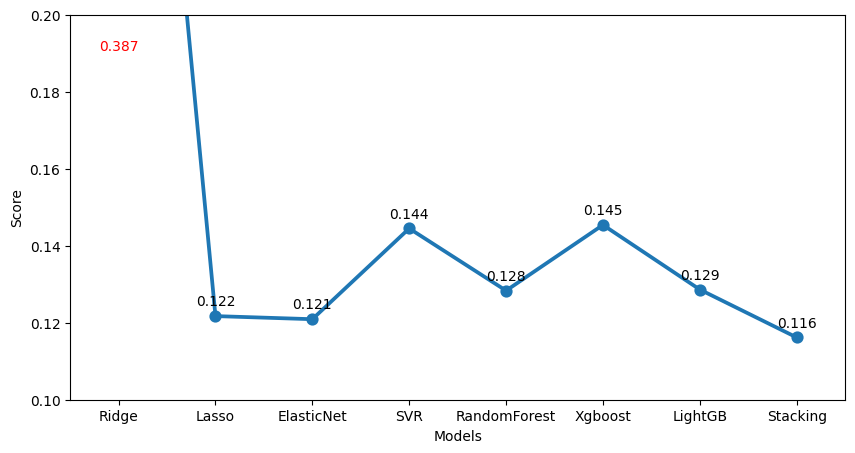

In [162]:
# Plot the results : 
d=pd.concat([pd.DataFrame(res_test,columns=['Score']),pd.DataFrame([*model_names,"Stacking"],columns=['Models'])],axis=1)
plt.figure(figsize=(10,5))
sns.pointplot(data=d,x='Models',y='Score')
plt.ylim(0.1,0.2)
for i in range(1,len(res_test)) : 
    plt.text(i, res_test[i]+0.002, str(round(res_test[i],3)),verticalalignment='bottom',horizontalalignment='center')
    
plt.text(0, 0.19, str(round(res_test[0],3)),verticalalignment='bottom',horizontalalignment='center',color='red');

In [163]:
# Final predictions shape : 
path=Path('train_final.csv').parent.absolute()
final_sub=pd.read_csv(path/'data/sample_submission.csv')
final_sub.shape, final_sub.head()

((1459, 2),
      Id      SalePrice
 0  1461  169277.052498
 1  1462  187758.393989
 2  1463  183583.683570
 3  1464  179317.477511
 4  1465  150730.079977)

In [164]:
# The best model for submission is the stacking model : 
final_sub['SalePrice']=np.round(np.exp(stacked_model.predict(test_scaled)),6)
final_sub.head()

# Write final submission in csv file to deliver : 
final_sub.to_csv(path/'final_submissions.csv', index=False)  